In [1]:
import pandas as pd
import numpy as np
import nltk

import datetime as dt

#nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestClassifier


#visualization
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
 
df1 = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
df1.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [2]:
# Statistics of numerical variables
df1.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Unnamed: 0,11742.500000,6779.968547,0.0,5871.25,11742.5,17613.75,23485.0
Clothing ID,918.118709,203.298980,0.0,861.00,936.0,1078.00,1205.0
Age,43.198544,12.279544,18.0,34.00,41.0,52.00,99.0
Rating,4.196032,1.110031,1.0,4.00,5.0,5.00,5.0
Recommended IND,0.822362,0.382216,0.0,1.00,1.0,1.00,1.0
Positive Feedback Count,2.535936,5.702202,0.0,0.00,1.0,3.00,122.0


In [3]:
df = df1.drop(df1.columns[[0,1,3,6]],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 7 columns):
Age                        23486 non-null int64
Review Text                22641 non-null object
Rating                     23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(3), object(4)
memory usage: 1.3+ MB


In [4]:
# Extracting Unique Count and Missing Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x,len(df[x].unique()),df[x].isnull().sum()])
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
pd.DataFrame(unique_count, columns=["Column","Unique","Missing"]).set_index("Column").T

Dataframe Dimension: 23486 Rows, 7 Columns


Column,Age,Review Text,Rating,Positive Feedback Count,Division Name,Department Name,Class Name
Unique,77,22635,5,82,4,7,21
Missing,0,845,0,0,14,14,14


In [5]:
# fill missing values
df['Review Text'] = df['Review Text'].fillna('')

# Create New Variables: 
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)
# Boolean for Positive and Negative Reviews
#df=df.loc[df.Rating!=3]
df["Sentiment"] = 0
df.loc[df.Rating >= 3,["Sentiment"]] = 1
df.head()

,Age,Review Text,Rating,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count,Character Count,Sentiment
0,33,Absolutely wonderful - silky and sexy and comf...,4,0,Initmates,Intimate,Intimates,8,53,1
1,34,Love this dress! it's sooo pretty. i happene...,5,4,General,Dresses,Dresses,62,303,1
2,60,I had such high hopes for this dress and reall...,3,0,General,Dresses,Dresses,98,500,1
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0,General Petite,Bottoms,Pants,22,124,1
4,47,This shirt is very flattering to all due to th...,5,6,General,Tops,Blouses,36,192,1


# Exploratory Data Analysis (EDA)

In [6]:
# Statistics of numerical variables
df.describe().T.drop("count",axis=1)

,mean,std,min,25%,50%,75%,max
Age,43.198544,12.279544,18.0,34.0,41.0,52.0,99.0
Rating,4.196032,1.110031,1.0,4.0,5.0,5.0,5.0
Positive Feedback Count,2.535936,5.702202,0.0,0.0,1.0,3.0,122.0
Word Count,58.030869,30.176433,0.0,34.0,57.0,87.0,115.0
Character Count,297.581666,152.572686,0.0,173.0,292.0,451.0,508.0
Sentiment,0.897513,0.303294,0.0,1.0,1.0,1.0,1.0


In [7]:
# Statistics of categorical variables
df[["Division Name","Department Name","Class Name"]].describe(include=["O"]).T.drop("count",axis=1)

,unique,top,freq
Division Name,3,General,13850
Department Name,6,Tops,10468
Class Name,20,Dresses,6319


In [8]:
df["Sentiment"].value_counts()

1    21079
0     2407
Name: Sentiment, dtype: int64

In [9]:
#imbalanced data
df["Sentiment"].value_counts()[0]/df["Sentiment"].value_counts()[1]

0.1141894776792068

In [10]:
df["Class Name"].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: Class Name, dtype: int64

In [11]:
df["Department Name"].value_counts()

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: Department Name, dtype: int64

In [12]:
df["Division Name"].value_counts()

General           13850
General Petite     8120
Initmates          1502
Name: Division Name, dtype: int64

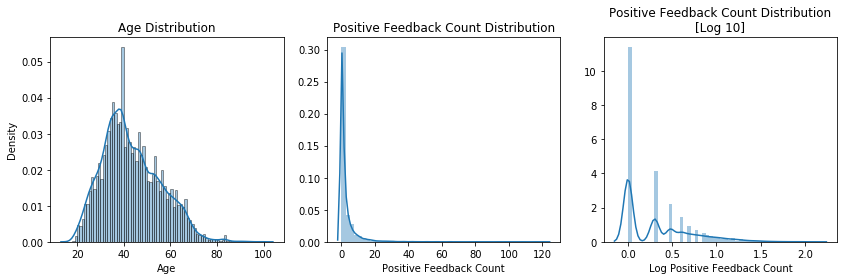

In [13]:
# Continous Distributions. age, positive feedback
f, ax = plt.subplots(1,3,figsize=(12,4), sharey=False)
sns.distplot(df1['Age'], hist=True, kde=True,hist_kws={'edgecolor':'black'},bins=int(99-18), ax=ax[0])
ax[0].set_title("Age Distribution")
ax[0].set_ylabel("Density")
sns.distplot(df["Positive Feedback Count"], ax=ax[1])
ax[1].set_title("Positive Feedback Count Distribution")
sns.distplot(np.log10((df["Positive Feedback Count"][df["Positive Feedback Count"].notnull()]+1)), ax=ax[2])
ax[2].set_title("Positive Feedback Count Distribution\n[Log 10]")
ax[2].set_xlabel("Log Positive Feedback Count")
plt.tight_layout()
plt.show()

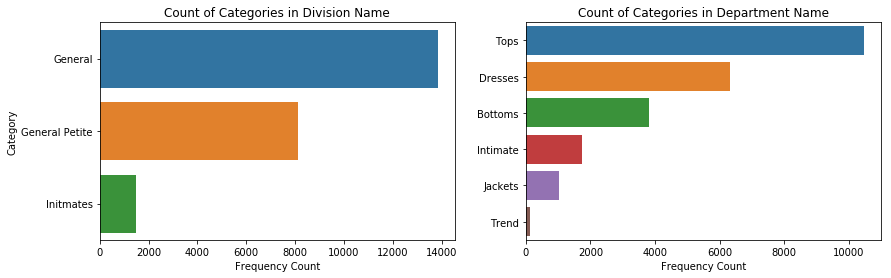

In [14]:
# Count division,  Count department
row_plots = ["Division Name","Department Name"]
f, axes = plt.subplots(1,len(row_plots), figsize=(14,4), sharex=False)

for i,x in enumerate(row_plots):
    sns.countplot(y=x, data=df,order=df[x].value_counts().index, ax=axes[i])
    axes[i].set_title("Count of Categories in {}".format(x))
    axes[i].set_xlabel("")
    axes[i].set_xlabel("Frequency Count")
axes[0].set_ylabel("Category")
axes[1].set_ylabel("")
plt.show()

Text(0.5, 1.0, 'Frequency Count of Rating')

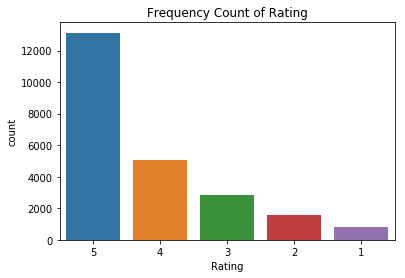

In [15]:
# Frequency Count of Ratings
sns.countplot(x="Rating", data=df,order=df["Rating"].value_counts().index)
plt.title("Frequency Count of Rating")

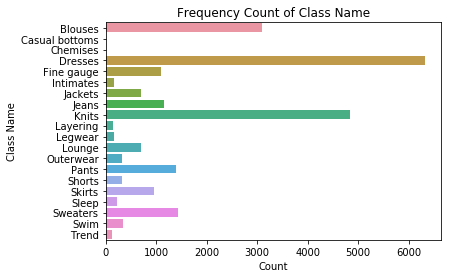

In [16]:
#Frequency Count of Class Name   /  alphe order
avgdf1 = df.groupby('Class Name').agg({'Rating': np.average})
avgdf1['Class'] = avgdf1.index
avgdf1.index
sns.countplot(y="Class Name", data=df, order=avgdf1.index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

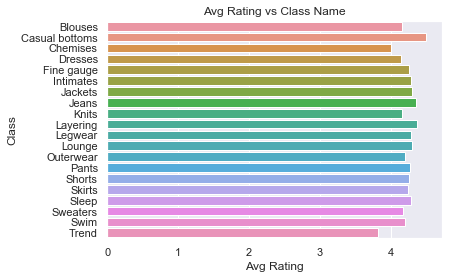

In [17]:
## Multivariate Analysis
# Avg Rating vs Class Name  / alphabetic order

sns.set(font_scale=1)
sns.barplot(x="Rating", y="Class", data=avgdf1)
plt.title("Avg Rating vs Class Name")
plt.xlabel("Avg Rating")
plt.show()

Text(0.5, 1.0, 'Rating vs Age')

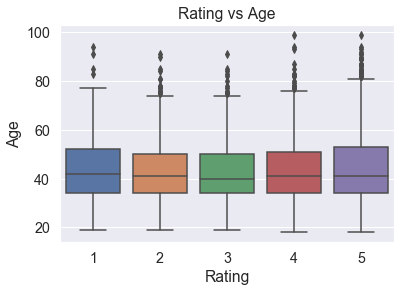

In [18]:
# Rating vs Age
sns.set(font_scale=1.3)
sns.boxplot(x = 'Rating', y = 'Age', data = df)
plt.title("Rating vs Age")

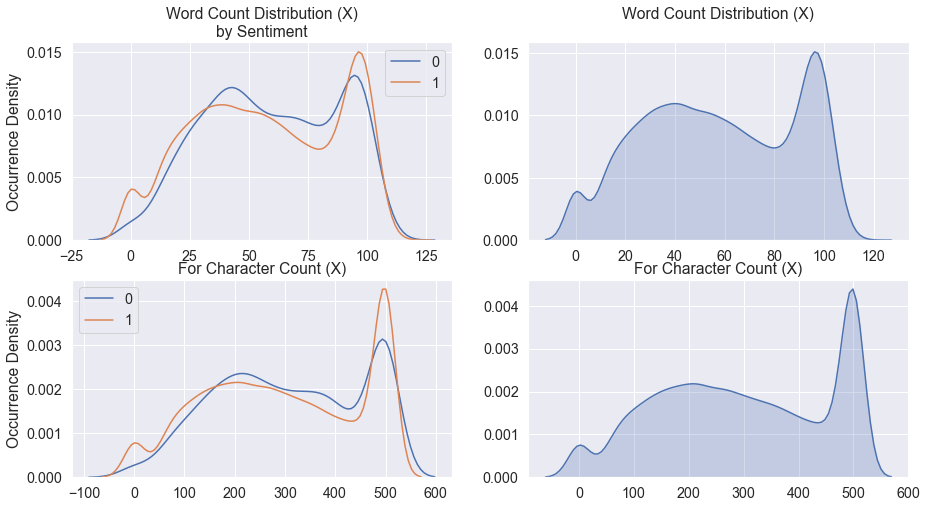

Correlation Coefficient of Word Cound and Character Count: 0.99

Total Word Count is: 1362913
Total Character Count is: 6989003


,count,mean,std,min,25%,50%,75%,max
Word Count,23486.0,58.030869,30.176433,0.0,34.0,57.0,87.0,115.0
Character Count,23486.0,297.581666,152.572686,0.0,173.0,292.0,451.0,508.0


In [19]:
# Word Count & Character Count vs Sentiment
f, axes = plt.subplots(2,2, figsize=(15,8), sharex=False)
for ii, xvar in enumerate(['Word Count', "Character Count"]):
    for i,y in enumerate(["Sentiment"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Occurrence Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,1])
    axes[ii,1].set_xlabel("")
    if ii is 0:
        axes[ii,1].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,1].set_title('For {} (X)'.format(xvar))
    axes[ii,1].legend_.remove()
plt.show()

print("Correlation Coefficient of Word Cound and Character Count: {}".format(
    round(df["Word Count"].corr(df["Character Count"]), 2)))

print("\nTotal Word Count is: {}".format(df["Word Count"].sum()))
print("Total Character Count is: {}".format(df["Character Count"].sum()))
df[["Word Count","Character Count"]].describe().T


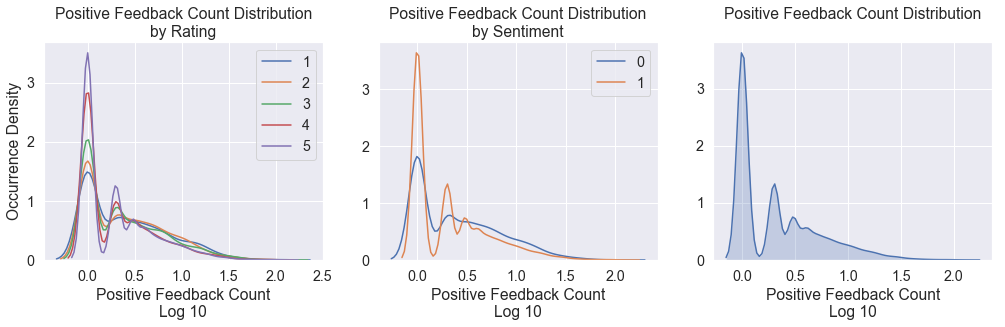

In [20]:
# Positive feedback vs Sentiment
f, axes = plt.subplots(1,3, figsize=(17,4), sharex=False)
xvar = 'Positive Feedback Count'
plotdf = np.log10(1+df['Positive Feedback Count'])
for i,y in enumerate(["Rating","Sentiment"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}\nLog 10".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution\nby {}'.format(xvar, y))
axes[0].set_ylabel('Occurrence Density')
# Plot 4
sns.kdeplot(plotdf,shade=True,ax=axes[2])
axes[2].set_xlabel("{}\nLog 10".format(xvar))
axes[2].set_title('{} Distribution\n'.format(xvar))
axes[2].legend_.remove()
plt.show()

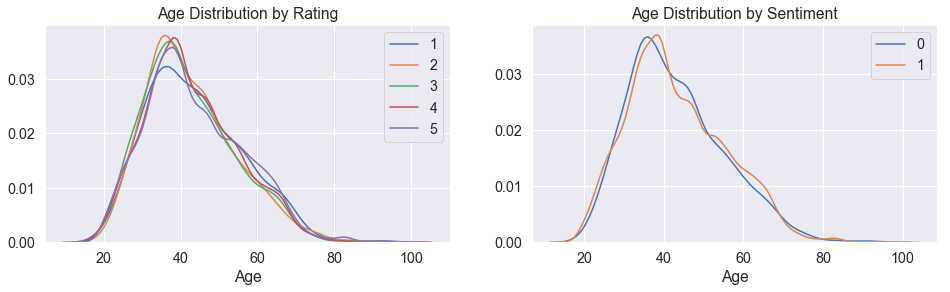

In [21]:
# age distribution vs sentiment
f, axes = plt.subplots(1,2, figsize=(16,4), sharex=False)
xvar = "Age"
plotdf = df["Age"]
for i,y in enumerate(["Rating","Sentiment"]):
    for x in set(df[y][df[y].notnull()]):
        sns.kdeplot(plotdf[df[y]==x], label=x, shade=False, ax=axes[i])
    axes[i].set_xlabel("{}".format(xvar))
    axes[i].set_label('Occurrence Density')
    axes[i].set_title('{} Distribution by {}'.format(xvar, y))

#for x in set(df["Class Name"][df["Class Name"].notnull()]):
#    sns.kdeplot(plotdf[df["Class Name"]==x], label=x, shade=False, ax=axes[2])

#axes[2].legend_.remove()
#axes[2].set_xlabel('{}'.format(xvar))
#axes[0].set_ylabel('Occurrence Density')
#axes[2].set_title('{} Distribution by {}'.format(xvar, "Class Name"))
plt.show()

# NLP - Word Distribution and Cloud

In [22]:
pd.set_option('max_colwidth', 500)
df[["Review Text", "Rating"]].sample(7)

,Review Text,Rating
1691,"These tights are so cute and can add some fun to any outfit. i paired with a mustard mini, denim shirt and desert boots! they do run small. i am a size 4 and had to get the m/l",5
17788,The material is soft and the length is great. you can wear it with short or skinny jeans. the only drawback is the color because it is so light. it is pastel so if you like pastels it will be great for you.,4
106,Was so excited to order this beautiful shirt! and the color sky is gorgeous! but as another reviewer said--it runs small. it was also way too short. so sadly i will be returning this. i gave it 5 stars because it is beautiful and great quality--it just didn't fit me.,4
7657,"I love the colors. originally purchased a large for my broad shoulders and it was too big and too long for 5'4"". exchanged it for a petit medium and it fits great. will have to wait for cooler days to wear it since it is a heavy cotton and the weather is still very hot intexas.",5
18115,"Received today, the fit is true to size quality fabric beautiful color. will go with so many things!",5
194,"Dress ran very large in every way. beautiful design, lining and quality material. i should have sized down 2 sizes. item is now sold out.",3
23203,"This is a very soft and feminine chemise. it is a little more see thru than i had anticipated, but i still love it!",4


In [23]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    words = [w for w in words if not w in stop_words] #3
    words = [w for w in words if not w.isdigit()]
    #words = [ps.stem(w) for w in words] #4
    return words

In [24]:
stopwords = set(STOPWORDS)
size = (10,7)

def cloud(text, title, stopwords=stopwords, size=size):
    """
    Function to plot WordCloud
    Includes: 
    """
    # Setting figure parameters
    mpl.rcParams['figure.figsize']=(10.0,10.0)
    mpl.rcParams['font.size']=12
    mpl.rcParams['savefig.dpi']=100
    mpl.rcParams['figure.subplot.bottom']=.1 
    
    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=stopwords,
                         ).generate(str(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    #plt.title(title, fontsize=30,color='y')
    plt.tight_layout(pad=0)
    plt.show()
    
# Frequency Calculation [One-Gram]
def wordfreqviz(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    matplotlib.style.use('ggplot')
    rslt.plot.bar(rot=0)

def wordfreq(text, x):
    word_dist = nltk.FreqDist(text)
    top_N = x
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
    return rslt

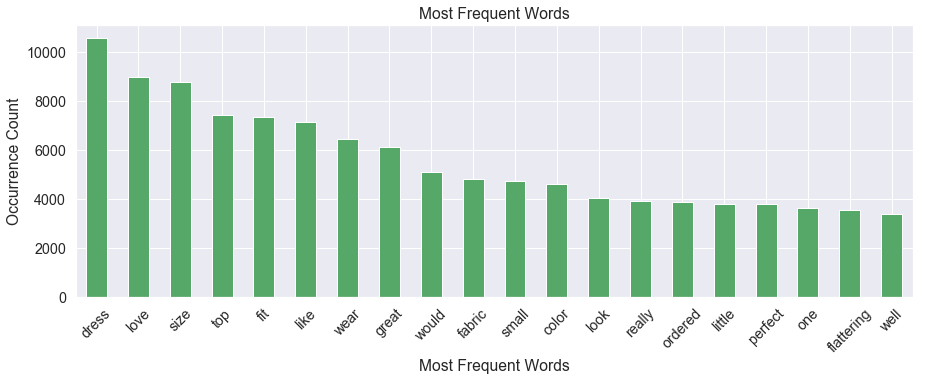

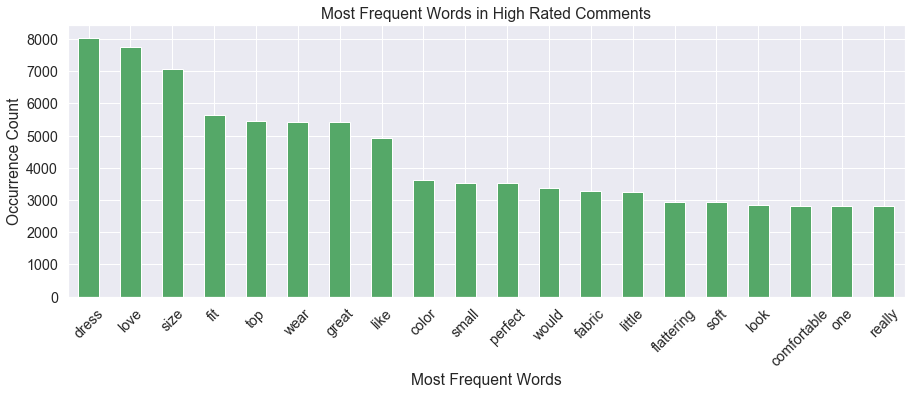

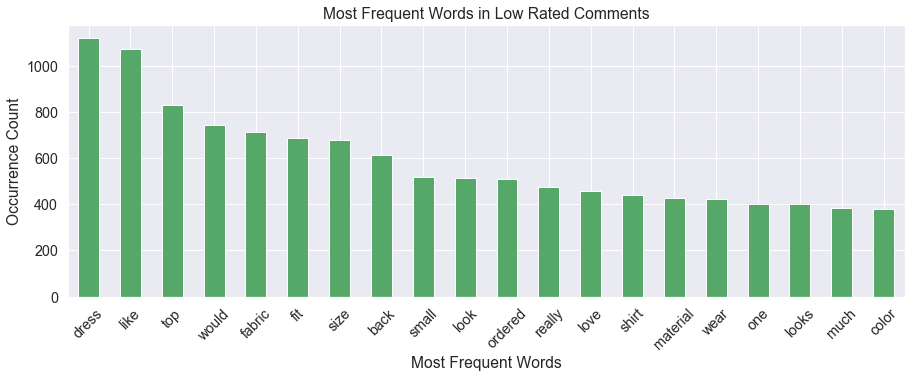

In [25]:
title ="Most Frequent Words"
temp = df['Review Text']#[df.Rating.astype(int) > 3]

wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

# High Rated
title ="Most Frequent Words in High Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) > 3]
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()

# Low Rated
title ="Most Frequent Words in Low Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]
wordfreq(preprocessing(temp),20).plot.bar(rot=45, legend=False,figsize=(15,5), color='g',
                          title= title)
plt.ylabel("Occurrence Count")
plt.xlabel("Most Frequent Words")
plt.show()


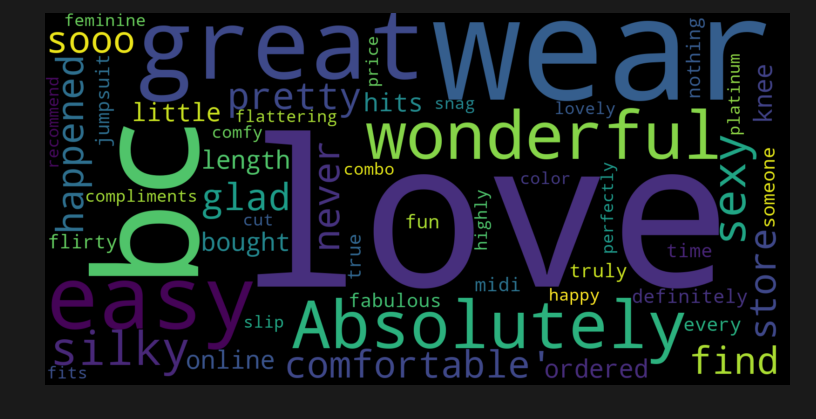

In [26]:
# Highly Rated
title ="Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) > 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop = set(STOPWORDS)
new_stop.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                + ["dress", "petite"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop)

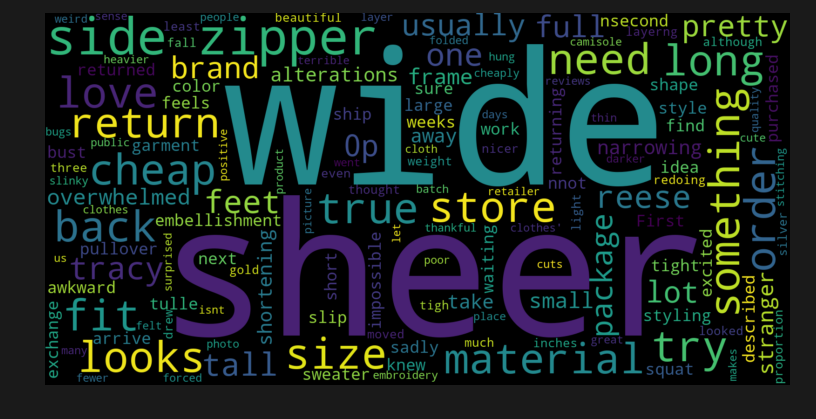

In [27]:
# lowly Rated
title ="Highly Rated Comments"
temp = df['Review Text'][df.Rating.astype(int) < 3]

# Modify Stopwords to Exclude Class types, suchs as "dress"
new_stop2 = set(STOPWORDS)
new_stop2.update([x.lower() for x in list(df["Class Name"][df["Class Name"].notnull()].unique())]
                  +["dress", "petite","skirt","shirt","buttons","coat","sleeves","look","will","make","wear","made","front","underneath"])

# Cloud
cloud(text= temp.values, title=title,stopwords= new_stop2)

# Data Preprocessing

In [28]:
#df['tokenized'] = df["Review Text"].astype(str).str.lower() # Turn into lower case text
#df['tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['tokenized']), axis=1) # Apply tokenize to each row
#df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) # Remove stopwords from each row
#df['tokenized'] = df['tokenized'].apply(lambda x: [w for w in x if not w.isdigit()])# Remove digits for each row
#df['tokenized'] = df['tokenized'].apply(lambda x: [ps.stem(w) for w in x]) # Apply stemming to each row
#all_words = nltk.FreqDist(preprocessing(df['Review Text'])) # Calculate word occurrence from whole block of text

#vocab_count = 200
#word_features= list(all_words.keys())[:vocab_count] # 2000 most recurring unique words
#print("Number of words columns (One Hot Encoding): {}".format(len(all_words)))
df=df.loc[df.Rating!=3]

In [29]:
vectorizer = CountVectorizer()
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

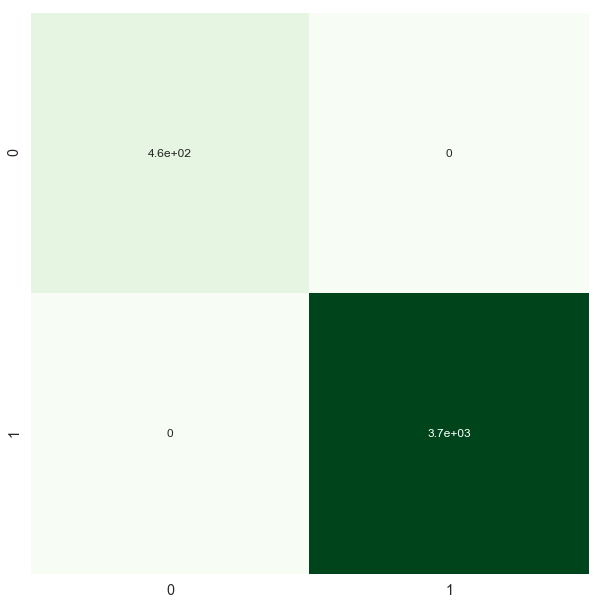

In [30]:
ideal=confusion_matrix(y_test.values, y_test.values)
sns.heatmap(ideal, annot = True, cmap="Greens",cbar=False);

# Modeling

## Baseline

In [31]:
from sklearn.metrics import accuracy_score

pred_base=np.ones((len(y_test),1),dtype=np.int8)#predict as the mode
accuracy_score(y_test,pred_base)

0.8889158379820519

## Logistic Regression

In [32]:
start=dt.datetime.now()
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:01.332323


In [33]:
print("Train score: %f" % lr.score(X_train, y_train))
print("Test score: %f" % lr.score(X_test, y_test))

Train score: 0.979505
Test score: 0.940092


In [34]:
#train_pred=lr.predict(X_train)
pred_lr_train = lr.predict_proba(X_train)[:,1]
pred_lr = lr.predict_proba(X_test)[:,1]
pred_lr_=lr.predict(X_test)

print('Train AUC: ', roc_auc_score(y_train, pred_lr_train))
print('Test AUC: ', roc_auc_score(y_test, pred_lr))

Train AUC:  0.9949895758608597
Test AUC:  0.9474916148864807


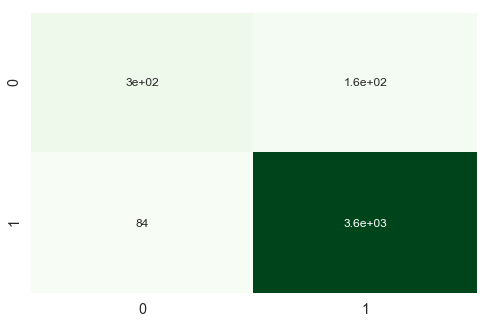

In [69]:
plt.figure(figsize=(8,5))
lr_cm=confusion_matrix(y_test.values, pred_lr_)
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False)

In [36]:
pred_lr_train_7=(pred_lr_train>.7)*1
pred_lr_7=(pred_lr>.7)*1
print("Train score: %f" % accuracy_score(y_train,pred_lr_train_7))
print("Test score: %f" % accuracy_score(y_test,pred_lr_7))

Train score: 0.979748
Test score: 0.932331


In [37]:
pred_lr_7

array([1, 1, 0, ..., 1, 1, 1])

In [38]:
start=dt.datetime.now()
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:01.307183


## Naive Bayse

In [39]:
start=dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.012466


In [40]:
print("Train score: %f" % nb.score(X_train, y_train))
print("Test score: %f" % nb.score(X_test, y_test))

Train score: 0.951249
Test score: 0.941790


In [41]:
pred_nb_train = nb.predict_proba(X_train)[:,1]
pred_nb = nb.predict_proba(X_test)[:,1]
pred_nb_=nb.predict(X_test)

print('Train AUC: ', roc_auc_score(y_train, pred_nb_train))
print('Test AUC: ', roc_auc_score(y_test, pred_nb))

Train AUC:  0.9705447376081553
Test AUC:  0.9472884657774178


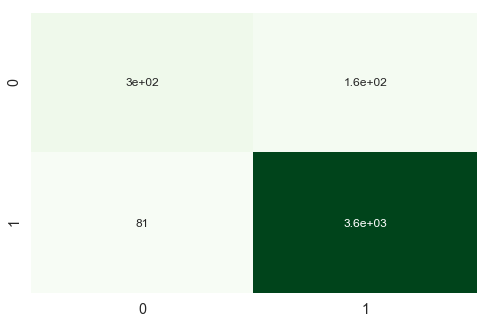

In [70]:
plt.figure(figsize=(8,5))
nb_cm=confusion_matrix(y_test.values, pred_nb_)
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False)

## SVM

In [43]:
start=dt.datetime.now()
svm = SVC(kernel='rbf', class_weight={1: 1, 0: 5})
svm.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:01:21.892519


In [44]:
print("Train score: %f" % svm.score(X_train, y_train))
print("Test score: %f" % svm.score(X_test, y_test))

Train score: 0.888128
Test score: 0.887461


In [45]:
pred_svm_train = svm.decision_function(X_train)
pred_svm = svm.decision_function(X_test)
pred_svm_=svm.predict(X_test)

print('Train AUC: ', roc_auc_score(y_train, pred_svm_train))
print('Test AUC: ', roc_auc_score(y_test, pred_svm))

Train AUC:  0.8952650703366993
Test AUC:  0.8964952310597711


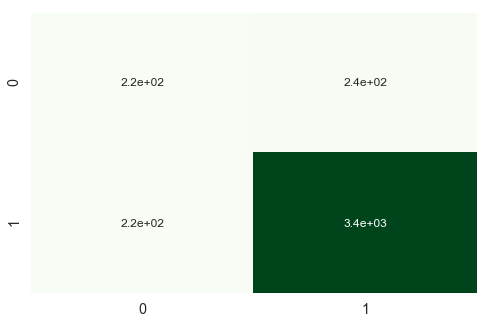

In [68]:
plt.figure(figsize=(8,5))
svm_cm=confusion_matrix(y_test.values, pred_svm_)
sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False)

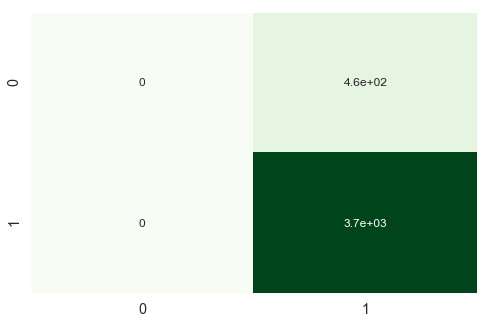

In [67]:
# before
plt.figure(figsize=(8,5))
ideal[0,0]=0
ideal[0,1]=458
sns.heatmap(ideal, annot = True, cmap="Greens",cbar=False)

## Random Forest

In [48]:
start=dt.datetime.now()
rf = RandomForestClassifier(n_estimators=350,max_features=.2, n_jobs=-1,class_weight={1: 1, 0: 10}, random_state=0)
rf.fit(X_train, y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:01:45.095606


In [49]:
print("Train score: %f" % rf.score(X_train, y_train))
print("Test score: %f" % rf.score(X_test, y_test))

Train score: 0.998242
Test score: 0.909047


In [50]:
pred_rf_train=rf.predict_proba(X_train)[:, 1]
pred_rf = rf.predict_proba(X_test)[:, 1]
pred_rf_=rf.predict(X_test)
print('Train AUC: ', roc_auc_score(y_train, pred_rf_train))
print('Test AUC: ', roc_auc_score(y_test, pred_rf))

Train AUC:  0.9996910137898238
Test AUC:  0.9042003014470652


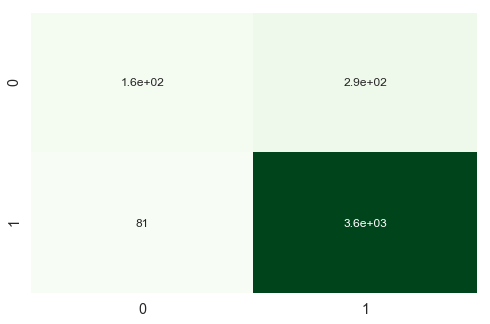

In [71]:
plt.figure(figsize=(8,5))
rf_cm=confusion_matrix(y_test.values, rf.predict(X_test))
sns.heatmap(rf_cm, annot = True, cmap="Greens",cbar=False);

# Model Comparison

In [52]:
lr_cm

array([[ 295,  163],
       [  84, 3581]])

In [53]:
nb_cm

array([[ 299,  159],
       [  81, 3584]])

In [54]:
svm_cm

array([[ 219,  239],
       [ 225, 3440]])

In [55]:
rf_cm

array([[ 164,  294],
       [  81, 3584]])

In [56]:
precision=[]
recall=[]
precision.append(round(precision_score(y_test, pred_lr_),3))
recall.append(round(recall_score(y_test, pred_lr_),3))
precision.append(round(precision_score(y_test, pred_nb_),3))
recall.append(round(recall_score(y_test, pred_nb_),3))
precision.append(round(precision_score(y_test, pred_svm_),3))
recall.append(round(recall_score(y_test, pred_svm_),3))
precision.append(round(precision_score(y_test, pred_rf_),3))
recall.append(round(recall_score(y_test, pred_rf_),3))
prec_rec=pd.DataFrame({'Precision':pd.Series(precision),'Recall':pd.Series(recall)})
prec_rec.index=['lr','nb','svm','rf']
print(prec_rec)

     Precision  Recall
lr       0.956   0.977
nb       0.958   0.978
svm      0.935   0.939
rf       0.924   0.978


<function matplotlib.pyplot.show(*args, **kw)>

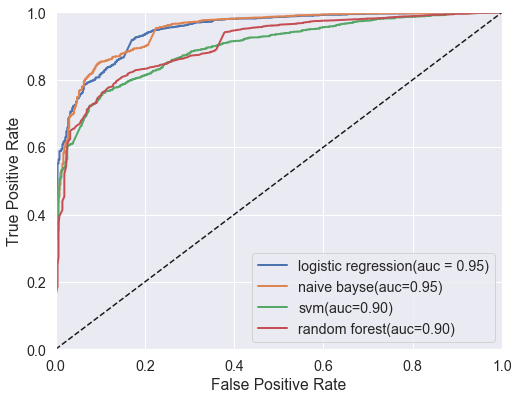

In [80]:
# Plot ROC curve

fpr_lr,tpr_lr,_ = roc_curve(y_test.values,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

fpr_nb,tpr_nb,_ = roc_curve(y_test.values,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

fpr_svm,tpr_svm,_ = roc_curve(y_test.values,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_rf,tpr_rf,_ = roc_curve(y_test.values,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, linewidth=2, label='logistic regression(auc = {:0.2f})'.format(roc_auc_lr)) 
plt.plot(fpr_nb, tpr_nb, linewidth=2, label='naive bayse(auc={:0.2f})'.format(roc_auc_nb)) 
plt.plot(fpr_svm, tpr_svm, linewidth=2, label='svm(auc={:0.2f})'.format(roc_auc_svm)) 
plt.plot(fpr_rf, tpr_rf, linewidth=2, label='random forest(auc={:0.2f})'.format(roc_auc_rf)) 


plt.plot([0, 1], [0, 1], 'k--') 
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="bottom right")

plt.show

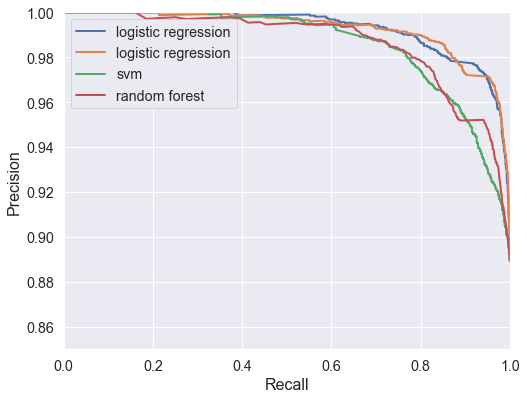

In [81]:
# Plot PR curve
plt.figure(figsize=(8,6))

prec_lr, rec_lr, thresholds = precision_recall_curve(y_test.values,pred_lr)
prec_nb, rec_nb, thresholds = precision_recall_curve(y_test.values,pred_nb)
prec_svm, rec_svm, thresholds = precision_recall_curve(y_test.values,pred_svm)
prec_rf, rec_rf, thresholds = precision_recall_curve(y_test.values,pred_rf)


plt.plot(rec_lr, prec_lr, linewidth=2,label='logistic regression')
plt.plot(rec_nb, prec_nb, linewidth=2,label='logistic regression')
plt.plot(rec_svm, prec_svm, linewidth=2,label='svm')
plt.plot(rec_rf, prec_rf, linewidth=2,label='random forest')
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0.85, 1])
plt.legend(loc="bottom left")
plt.show()

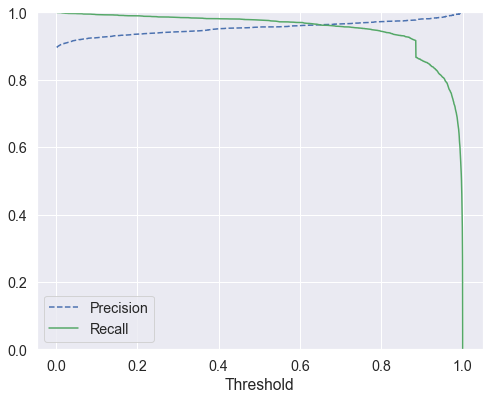

In [76]:
plt.figure(figsize=(8,6))
precisions, recalls, thresholds = precision_recall_curve(y_test.values,pred_lr)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
plt.xlabel("Threshold")
plt.legend(loc="bottom left")
plt.ylim([0, 1])
plt.show()

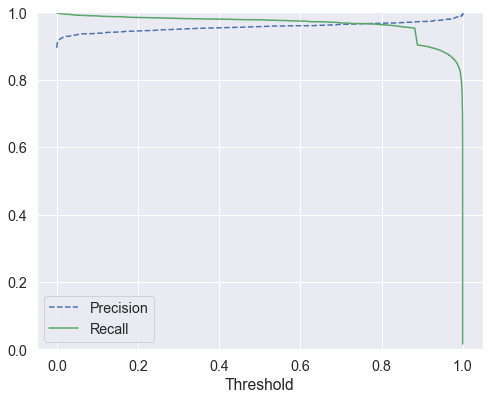

In [77]:
plt.figure(figsize=(8,6))
precisions, recalls, thresholds = precision_recall_curve(y_test.values,pred_nb)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
plt.xlabel("Threshold")
plt.legend(loc="bottom left")
plt.ylim([0, 1])
plt.show()

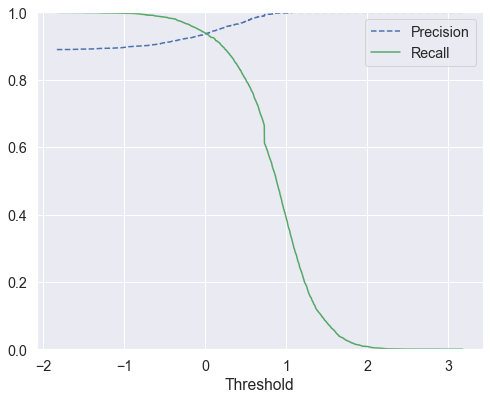

In [78]:
plt.figure(figsize=(8,6))
precisions, recalls, thresholds = precision_recall_curve(y_test.values,pred_svm)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
plt.xlabel("Threshold")
plt.legend(loc="bottom left")
plt.ylim([0, 1])
plt.show()

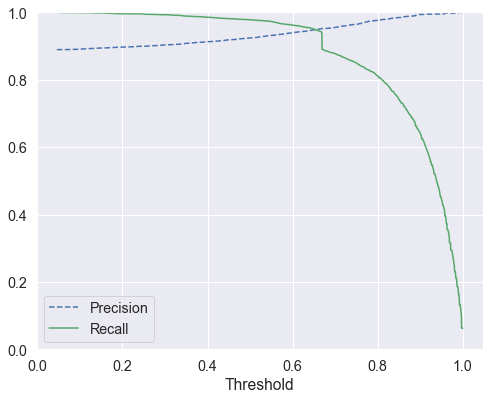

In [79]:
plt.figure(figsize=(8,6))
precisions, recalls, thresholds = precision_recall_curve(y_test.values,pred_rf)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
plt.xlabel("Threshold")
plt.legend(loc="bottom left")
plt.ylim([0, 1])
plt.show()